In [1]:
year = 'Y1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sacc
import pyccl as ccl
from scipy.interpolate import interp1d
from scipy.special import erf

# Fiducial cosmology
* Planck 2018 TT,TE,EE+lowE+lensing
* https://arxiv.org/abs/1807.06209 Table 2 second-to-last column
* for our fiducial cosmology we have 3 degenerate massive neutrinos with equal mass, and a total mass of 0.1 eV (to include the effect of massive neutrinos without having to do calculations for multiple masses)


In [3]:
fiducial_cosmology = {'name': 'desy3',
                      'h': 0.6736,
                      'Omega_m': 0.3153,
                      'Omega_b': 0.0493,
                      'A_s': 2.092e-9,
                      'n_s': 0.9656,
                      'w0': -1,
                      'wa': 0,
                      #'tau': 0.0536,
                      'sigma8': 0.8091,
                      'S8': 0.828
                     }

# $\ell$ binning choices

* decide whether to make bins smaller
* look at hsc, des, kids choices?
* I don't think there is any point in going to 15 000 so even if we want the same width we should be able to just make fewer bins

In [4]:
does_pt = False
does_TATT = False
auto_galaxy_clustering_only = False

nbin_ell = 20
lmin_bins = 20
lmax_bins = 2000

IA_model = 'NLA'
if does_TATT: IA_model = 'TATT'
    
gbias_model = 'lin_gbias'
if does_pt: gbias_model = 'nl_gbias'

twopoint_data = '3x2pt'
    
lbinning_str = str(nbin_ell)

# Galaxy clustering systematics and analysis choices

* nonlinear bias with Eulerian perturbation theory, redshift evolution (see bias challenge paper https://arxiv.org/abs/2307.03226, figure 7 of https://arxiv.org/pdf/2111.00501.pdf)
* kmax 0.1-0.2 h/Mpc
* redshift: shift and stretch?
* magnification
* redshift space distortions

In [5]:
if year=='Y1' or year==1 or year=='y1':
    # galaxy clustering fiducial systematic parameters
    linear_bias_lens = np.array([1.23852, 1.36452, 1.50445, 1.6498, 1.79915]) #add nonlinear bias
    kmax = 0.2*fiducial_cosmology['h']
    magnification_bias_lens = np.array([0,0,0,0,0]) #figure out fiducial values

    # galaxy clustering redshift bins
    nbin_z_lens = 5
    z0_lens = 0.26
    alpha_lens = 0.94
    sig_z_lens = 0.03
    z_min_lens = 0.2
    z_max_lens = 1.2
    
    # survey-informed parameters --TODO: update these
    Ngal_lens = 18 # Normalisation, galaxies/arcmin^2
    sky_area = 11808.28 #square degrees, this is still srd values for now

# Weak Lensing systematics and analysis choices

* TATT for intrinsic alignments
* Mean redshift shift and stretch
* Multiplicative Shear Bias
* using DESC SRD lmax cutoff, ell binning and z binning for now

In [6]:
if year=='Y1' or year==1 or year=='y1':
    # weak lensing shear (source sample)
    lmax_src = 2000
    
    z0_src = 0.13
    alpha_src = 0.78
    sig_z_src = 0.05  #(0.05(1+z))
    sig_e_src = 0.26
    nbin_z_src = 5
    
    Ngal_src = 10

In [7]:
def get_PT_biases(b1):
    b2 = 0.30 - 0.79*b1 + 0.20*(b1**2) + 0.12*(b1**3)
    bk2 =  0.66 - 0.57*b1
    bs2 = -4/7*(b1-1)
    b3nl = b1-1
    none_arr = [None, None, None, None, None]
    if not does_pt: return none_arr, none_arr, none_arr, none_arr
    return b2, bs2, bk2, b3nl

# CCL cosmology object
* Done: HMCode 2020 with baryons

In [8]:
cosmo = ccl.Cosmology(
    Omega_c=fiducial_cosmology['Omega_m']-fiducial_cosmology['Omega_b'],
    Omega_b=fiducial_cosmology['Omega_b'],
    w0=-1.0,
    wa=0.0,
    A_s = fiducial_cosmology['A_s'],
    n_s=fiducial_cosmology['n_s'],
    h=fiducial_cosmology['h'],
    Omega_k=0.0,
    m_nu = 0.1,
    mass_split = 'equal',
    matter_power_spectrum = "camb",
    extra_parameters = {"camb": {"halofit_version": "mead2020_feedback",
                                     "HMCode_logT_AGN": 7.8}}
)

In [9]:
if year=='Y1' or year==1 or year=='y1':

    #All other Systematic Parameters

    #TATT IA
    # Bare CCL setup
    a_1 = 1.0
    a_2 = 1.0
    b_ta = 0.5
    a_d = b_ta * a_1
    eta_1 = -1.0
    eta_2 = -1.5
    z_pivot = 0.62
    if not does_TATT:
        a_2 = 0.0
        a_d = 0.0
        eta_2 = 0.0
    #Shear Calibration
    s_cal = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

    k_max = 0.2 / fiducial_cosmology['h'] #in Mpc^-1
    if not does_pt: kmax = 0.1/ fiducial_cosmology['h']
    
    #THIS IS JUST APPROXIMATE
    #need the n(z) distributions first to calculate true <z>
    z_mean_lens = np.array([0.3, 0.5, 0.7, 0.9, 1.1])
    a_mean_lens = 1/(1+z_mean_lens)
    l_max_lens =  k_max * cosmo.comoving_radial_distance(a_mean_lens) + 0.5
    print(l_max_lens)
    
    #1-Loop Galaxy Bias
    b_1 = 1.05/cosmo.growth_factor(a_mean_lens)
    b_2, b_s, b_k, b_3 = get_PT_biases(b_1)

    print(b_1)
    print(b_2)
    print(b_s)
    print(b_k)
    print(b_3)

[ 367.6158588   579.69089554  767.44594092  933.54261404 1080.83381786]
[1.231994   1.36683885 1.50929764 1.65731706 1.80939185]
[None, None, None, None, None]
[None, None, None, None, None]
[None, None, None, None, None]
[None, None, None, None, None]


# $\ell$ binning

* currently matches DESC SRD
* consider changing binning (smaller lmax, narrower bins?)
* should we use a more realistic ell binning function based on mask

In [10]:
ell_edges = np.geomspace(lmin_bins, lmax_bins, nbin_ell+1)
ell_centers = [lmin_bins**(1-(i+0.5)/nbin_ell)*lmax_bins**((i+0.5)/nbin_ell) for i in range(nbin_ell)]
print(ell_centers)

[2.3318288023596634, 3.1697863849222268, 4.308869380063767, 5.857289129250473, 7.962143411069944, 10.823390530929272, 14.712845089192829, 19.999999999999996, 27.187127817570516, 36.956995948445815, 50.2377286301916, 68.29097747667205, 92.8317766722556, 126.19146889603866, 171.53917971817881, 233.18288023596645, 316.9786384922228, 430.8869380063769, 585.7289129250474, 796.2143411069947, 1082.3390530929275, 1471.2845089192829, 1999.9999999999998, 2718.7127817570513, 3695.699594844581, 5023.77286301916, 6829.0977476672015, 9283.177667225555, 12619.14688960386, 17153.917971817875]


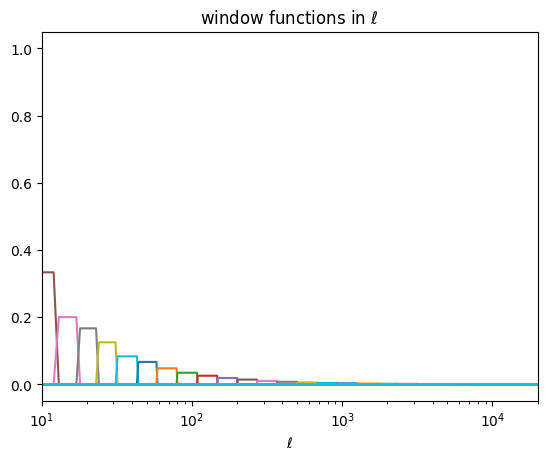

In [11]:
# tophat window functions in ell (use more realistic window fns?)
ell_unbinned = np.arange(0, lmax_bins+1)
n_ell_unbinned = len(ell_unbinned)
ell_windows = np.zeros([len(ell_unbinned), nbin_ell])
for i in range(nbin_ell):
    ell_windows[:,i] = (ell_unbinned>=ell_edges[i]) & (ell_unbinned<=ell_edges[i+1])
    ell_windows[:,i]/=np.sum(ell_windows[:,i])
    plt.plot(ell_unbinned, ell_windows[:,i], label=r'$\ell$ window '+str(i+1))
plt.xlim(10, lmax_bins)
plt.xscale('log')
plt.xlabel('$\ell$')
plt.title('window functions in $\ell$')
plt.show()

In [12]:
# Create a SACC bandpower window object
sacc_ell_windows = sacc.BandpowerWindow(ell_unbinned, ell_windows)

# Galaxy clustering

## z binning

* same as DESC SRD (5 equally spaced bins from z=0.2-1.2 for LSST y1)
* no cross spectra between bins (look into whether crossing neighbouring bins adds signal)

In [14]:
def get_redshift_distribution(z, z0, alpha): # shape, not normalized
    return (z / z0)**2. * np.exp(-(z / z0)**alpha)

In [15]:
def avg_z_int(z, splined):
    return z * splined(z)

def nz_int(z, sig_e, z_max, z_min, splined):
    sig_e *= (1+z)
    upper_lim = (z-z_max)/(sig_e*np.sqrt(2))
    lower_lim = (z-z_min)/(sig_e*np.sqrt(2))
    return  0.5*(erf(lower_lim)-erf(upper_lim))*splined(z)

def get_nz_bins_from_zmid(z_arr, ngal, nz, sig_z, z_lower_bounds, z_upper_bounds, zmids=None, title=''):
    nz_bins = []
    z_avgs = []
    nz_avgs = []
    if zmids is None:
        zmids = (z_lower_bounds + z_upper_bounds)/2
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].plot(z_arr, nz, label='total nz')
    splined = interp1d(z_arr, nz)
    for i, zmin in enumerate(z_lower_bounds):
        zmax = z_upper_bounds[i]
        zmid = zmids[i]        
        nz_bin_i = np.zeros_like(z_arr)
        nz_bin_i[(z_arr>zmin) & (z_arr<zmax)] = nz[(z_arr>zmin) & (z_arr<zmax)]
        ax[0].plot(z_arr, nz_bin_i, label='z bin %d'%(i+1))
        ax[0].set_xlabel('$z$')
        ax[0].set_ylabel('$p(z)$')
        ax[0].set_title('before gaussian binning')
        ax[0].set_xlim(0,2)

        ax[0].vlines(zmid, 0, np.amax(nz), color='k', linestyle=':')
        norm, e = scipy.integrate.quad(nz_int, z_arr[0], z_arr[-1], args=(sig_z, zmax, zmin, splined))
        nz_bin_i = nz_int(z_arr, sig_z, zmax, zmin, splined)/norm
        nz_bins.append(nz_bin_i)
        splined_2 = interp1d(z_arr, nz_bin_i)
        z_avgs.append((scipy.integrate.quad(avg_z_int, zmin, zmax, args=(splined_2))[0])/(scipy.integrate.quad(splined_2, zmin, zmax)[0]))
        nz_avgs.append(norm*ngal)
        ax[1].plot(z_arr, nz_bin_i, label='z bin %d'%(i+1))

        ax[1].set_xlabel('$z$')
        ax[1].set_title('after gaussian binning')
        ax[1].set_xlim(0,2)
        ax[1].vlines(z_avgs[-1], 0, np.amax(nz_bin_i), color='k', linestyle=':')

        
    plt.legend()
    plt.suptitle(title, fontsize=15)
    plt.show()
    return z_avgs, nz_avgs, nz_bins

In [16]:
z_arr = np.linspace(0., 5., 5001)

/tmp/ipykernel_199237/4171376416.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  z_avgs.append((scipy.integrate.quad(avg_z_int, zmin, zmax, args=(splined_2))[0])/(scipy.integrate.quad(splined_2, zmin, zmax)[0]))


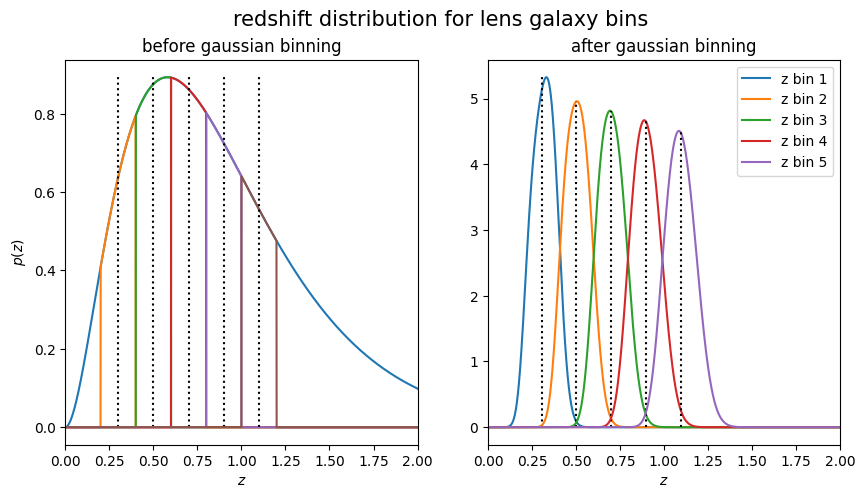

[0.3083232685515537, 0.5011373846158427, 0.6981257392184467, 0.8964730913147888, 1.0954122947279203]
[2.2504192424711285, 3.098089914346935, 3.070682456098286, 2.594693076250891, 1.997667876075201]
[0.2 0.4 0.6 0.8 1. ]
[187.72731737 289.66256783 382.14571619 464.64237246 538.07279115]


In [17]:
# z binning galaxy clustering (lens sample): evenly spaced redshift bins
bin_edges_lens = np.linspace(z_min_lens, z_max_lens, nbin_z_lens+1)
z_bounds_low_lens = bin_edges_lens[:-1]
z_bounds_high_lens = bin_edges_lens[1:]

pz_lens = get_redshift_distribution(z_arr, z0_lens, alpha_lens)
norm, e = scipy.integrate.quad(get_redshift_distribution, 0, 10, args=(z0_lens, alpha_lens))
pz_lens = pz_lens/norm  
z_avgs_lens, nz_avgs_lens, pz_bins_lens = get_nz_bins_from_zmid(z_arr, Ngal_lens, pz_lens, sig_z_lens, z_bounds_low_lens, z_bounds_high_lens, title='redshift distribution for lens galaxy bins')

chis = ccl.comoving_radial_distance(cosmo, 1/(1+np.array(z_avgs_lens))) # Mpc
lmax_lens_zbins = kmax*chis-0.5
print(z_avgs_lens)
print(nz_avgs_lens)
print(z_bounds_low_lens)
print(lmax_lens_zbins)

In [19]:
s = sacc.Sacc()
tracers_lens=[]
tracers_lens_nobias = []

for i in range(nbin_z_lens):
    # galaxy clustering CCL tracer for computing mock datavector
    tracers_lens.append(ccl.NumberCountsTracer(cosmo, 
                                          has_rsd=False, 
                                          dndz=(z_arr, pz_bins_lens[i]), 
                                          bias=(z_arr,np.ones(len(z_arr))), 
                                          mag_bias=None
                                        ))
                                        
    tracers_lens_nobias.append(ccl.NumberCountsTracer(cosmo, 
                                          has_rsd=False, 
                                          dndz=(z_arr, pz_bins_lens[i]), 
                                          bias=None, 
                                          mag_bias=(z_arr, magnification_bias_lens[i]*np.ones(len(z_arr)))
                                        ))    
    # galaxy clustering SACC tracer for saving to file later
    s.add_tracer('NZ', "lens%d"%i,  
                 quantity='galaxy_density', 
                 z=z_arr,  
                 nz=pz_bins_lens[i]) 

# Weak lensing

## source z bins
equal number binning


In [20]:
def get_fraction_in_redshift_bin(zmin, zmax, z0, alpha):
    i, e1 = scipy.integrate.quad(get_redshift_distribution, zmin, zmax, args=(z0, alpha))
    i_all_z, e2 = scipy.integrate.quad(get_redshift_distribution, 0, 10, args=(z0, alpha))
    fraction_in_bin = i/i_all_z # what fraction of the total galaxies are between redshifts zmin and zmax
    return fraction_in_bin

#need to get equal for GAUSSIAN bins
def get_equal_number_binning_bounds(nbin_z, ngal, splined, z_arr, sig_e, z0, alpha):
    z_bounds = [0]
    i_all_z, e2 = scipy.integrate.quad(get_redshift_distribution, 0, 10, args=(z0, alpha))

    for i in range(nbin_z-1):
        # use cumulative redshift distribution to solve for zmax 
        # such that 1/nbin_z of the galaxies are in each bin
        sol = scipy.optimize.root_scalar(lambda zmax, zmin, bin_number: 
            get_fraction_in_redshift_bin(zmin, zmax, z0, alpha) - (bin_number+1)/nbin_z,
            args = (0,i), method='bisect', bracket=[0., 5.])
        assert(sol.converged)
        z_bounds.append(sol.root)

    z_bounds.append(5) #technically infinity since there is no upper bound but this is a pain numerically, and redshift distribution falls before then

    return z_bounds

def nz_integrated(z, sig_e, zmax, zmin, splined):
    return scipy.integrate.quad(nz_int, z[0], z[-1], args=(sig_e, zmax, zmin, splined))[0]

def get_nz_bins_eq(z_arr, ngal, nz, sig_z, z_lower_bounds, z_upper_bounds, title=''):
    nz_bins = []
    z_avgs = []
    nz_avgs = []
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    splined = interp1d(z_arr, nz)

    for i, zmin in enumerate(z_lower_bounds):
        zmax = z_upper_bounds[i]
        
        nz_bin_i = np.zeros_like(z_arr)
        nz_bin_i[(z_arr>zmin) & (z_arr<zmax)] = nz[(z_arr>zmin) & (z_arr<zmax)]
        dz = z_arr[1]-z_arr[0]
        ax[0].plot(z_arr, nz_bin_i, label='z bin %d'%(i+1))
        ax[0].set_xlabel('$z$')
        ax[0].set_ylabel('$p(z)$')
        ax[0].set_title('before gaussian binning')
        ax[0].set_xlim(0,2)
        
        norm, e = scipy.integrate.quad(nz_int, z_arr[0], z_arr[-1], args=(sig_z, zmax, zmin, splined))
        nz_bin_i = nz_int(z_arr, sig_z, zmax, zmin, splined)/norm
        nz_bins.append(nz_bin_i)

        splined_2 = interp1d(z_arr, nz_bin_i)
        z_avgs.append((scipy.integrate.quad(avg_z_int, zmin, zmax, args=(splined_2))[0])/(scipy.integrate.quad(splined_2, zmin, zmax)[0]))
        nz_avgs.append(norm*ngal)
        ax[1].plot(z_arr, nz_bin_i, label='z bin %d'%(i+1))
        ax[1].set_xlabel('$z$')
        ax[1].set_title('after gaussian binning')
        ax[1].set_xlim(0,2)
        ax[1].vlines(z_avgs[-1], 0, np.amax(nz_bin_i), color='k', linestyle=':')

    plt.legend()
    plt.suptitle(title, fontsize=15)
    plt.show()

    return z_avgs, nz_avgs, nz_bins

/tmp/ipykernel_199237/3117838376.py:47: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  norm, e = scipy.integrate.quad(nz_int, z_arr[0], z_arr[-1], args=(sig_z, zmax, zmin, splined))
/tmp/ipykernel_199237/3117838376.py:52: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  z_avgs.append((scipy.integrate.quad(avg_z_int, zmin, zmax, args=(splined_2))[0])/(scipy.integrate.quad(splined_2, zmin, zmax)[0]))
/tmp/ipykernel_199237/3117838376.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably

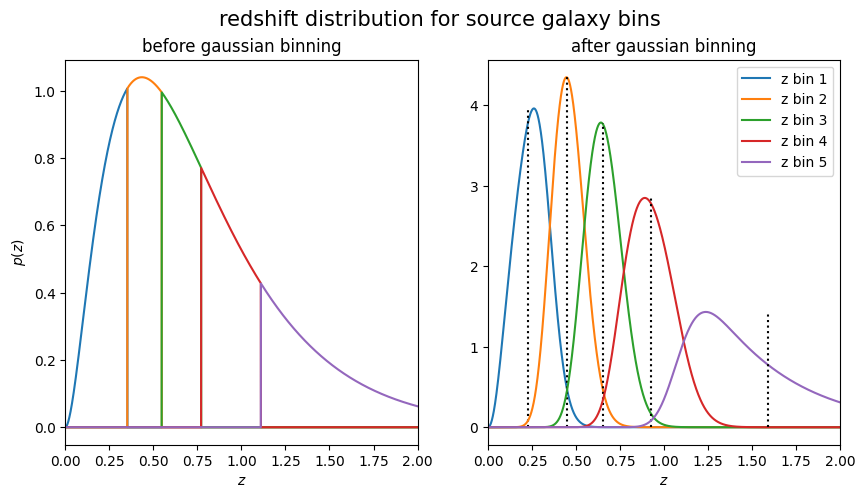

[0.2253273944137912, 0.4490567958326107, 0.6545664037512012, 0.9258332934738261, 1.5905474641826118]
[0, 0.35249940071821584, 0.5471735370940678, 0.7715892988028372, 1.1100640283086705, 5]


In [21]:
# z binning weak lensing source sample: source galaxies use equal number binning
pz_src = get_redshift_distribution(z_arr, z0_src, alpha_src)
norm, e = scipy.integrate.quad(get_redshift_distribution, 0, 10, args=(z0_src, alpha_src))
pz_src = pz_src/norm 
splined_src = interp1d(z_arr, pz_src)

#get_equal_gaussian_bins(nbin_z_src, Ngal_src, splined_src, z_arr, sig_z_src, z0_src, alpha_src)
bin_edges_src = get_equal_number_binning_bounds(nbin_z_src, Ngal_src, splined_src, z_arr, sig_z_src, z0_src, alpha_src)
z_bounds_low_src = np.array(bin_edges_src[:-1])
z_bounds_high_src = np.array(bin_edges_src[1:])


z_avgs_src, nz_avgs_src, pz_bins_src = get_nz_bins_eq(z_arr, Ngal_src, pz_src, sig_z_src,
                                     z_bounds_low_src, z_bounds_high_src,
                                     title='redshift distribution for source galaxy bins')
print(z_avgs_src)
print(bin_edges_src)

## weak lensing ccl and sacc tracers

In [22]:
tracers_src=[]
tracers_lensing_kernel = []
for i in range(nbin_z_src):
    # weak lensing CCL tracer for computing mock datavector
    tracers_src.append(ccl.WeakLensingTracer(cosmo,
                                             has_shear = False,
                                             dndz=(z_arr, pz_bins_src[i]),
                                             ia_bias = (z_arr, np.ones_like(z_arr)),
                                             use_A_ia=False
                                             ))
    tracers_lensing_kernel.append(ccl.WeakLensingTracer(cosmo,
                                                        has_shear=True,
                                                        dndz=(z_arr, pz_bins_src[i]),
                                                        ia_bias=None
                                                        ))
    # weak lensing SACC tracer for saving to file later
    s.add_tracer("NZ", "src%d"%i, 
                 quantity='galaxy_shear',
                 z=z_arr,
                 nz=pz_bins_src[i])

# Calling Eulerian PT Calculator

We will now define and call the PT Calculator to find the higher-order biased P(k)s

Divergences may exist at extremely small ell i.e. O(1). You can use linear theory in this regime, though

In [29]:
c_1, c_d, c_2 = ccl.nl_pt.translate_IA_norm(
    cosmo, z=z_arr, a1=a_1, a1delta=a_d, a2=a_2, Om_m2_for_c2=False
)

# Code that creates a Pk2D object:
ptc = ccl.nl_pt.EulerianPTCalculator(
    with_NC=True,
    with_IA=True,
    log10k_min=-4,
    log10k_max=4,
    nk_per_decade=200,
    cosmo=cosmo,
)

ptc_lin = ccl.nl_pt.EulerianPTCalculator(
    with_NC=True,
    with_IA=True,
    log10k_min=-4,
    log10k_max=4,
    nk_per_decade=200,
    cosmo=cosmo,
    b1_pk_kind = 'linear'
)


a_1_z = ((1+z_arr)/(1+z_pivot))**eta_1
a_2_z = ((1+z_arr)/(1+z_pivot))**eta_2
ptt_i = ccl.nl_pt.PTIntrinsicAlignmentTracer(
    c1=(z_arr, c_1*a_1_z), c2=(z_arr, c_2*a_2_z), cdelta=(z_arr, c_d*a_1_z)
)
ptt_m = ccl.nl_pt.PTMatterTracer()
pk_mm = ptc.get_biased_pk2d(tracer1=ptt_m, tracer2=ptt_m)
pk_im = ptc.get_biased_pk2d(tracer1=ptt_i, tracer2=ptt_m)
pk_ii = ptc.get_biased_pk2d(tracer1=ptt_i, tracer2=ptt_i)

ptt_i_lin = ccl.nl_pt.PTIntrinsicAlignmentTracer(
    c1=(z_arr, c_1*a_1_z), c2=(z_arr, c_2*a_2_z), cdelta=(z_arr, c_d*a_1_z)
)
pk_mm_lin = ptc_lin.get_biased_pk2d(tracer1=ptt_m, tracer2=ptt_m)
pk_im_lin = ptc_lin.get_biased_pk2d(tracer1=ptt_i_lin, tracer2=ptt_m)
pk_ii_lin = ptc_lin.get_biased_pk2d(tracer1=ptt_i_lin, tracer2=ptt_i_lin)



ptt_g = []
pk_gi = []
pk_gm = []
pk_gg = []

ptt_g_lin = []
pk_gi_lin = []
pk_gm_lin = []
pk_gg_lin = []
for i in range(nbin_z_lens):
    ptt_g.append(ccl.nl_pt.PTNumberCountsTracer(b1=b_1[i], b2=b_2[i], bs=b_s[i], bk2 = b_k[i], b3nl=b_3[i]))
    ptt_g_lin.append(ccl.nl_pt.PTNumberCountsTracer(b1=b_1[i], b2=b_2[i], bs=b_s[i], bk2 = b_k[i], b3nl=b_3[i]))

for i in range(nbin_z_lens):
    pk_gi.append(ptc.get_biased_pk2d(tracer1=ptt_g[i], tracer2=ptt_i))
    pk_gm.append(ptc.get_biased_pk2d(tracer1=ptt_g[i], tracer2=ptt_m))
    pk_gi_lin.append(ptc_lin.get_biased_pk2d(tracer1=ptt_g_lin[i], tracer2=ptt_i_lin))
    pk_gm_lin.append(ptc_lin.get_biased_pk2d(tracer1=ptt_g_lin[i], tracer2=ptt_m))
    temp = []
    temp_lin = []
    for j in range(nbin_z_lens):
        temp.append(ptc.get_biased_pk2d(tracer1=ptt_g[i], tracer2=ptt_g[j]))
        temp_lin.append(ptc_lin.get_biased_pk2d(tracer1=ptt_g_lin[i], tracer2=ptt_g_lin[j]))
    pk_gg.append(temp)
    pk_gg_lin.append(temp_lin)

print(type(pk_gg[0]), type(pk_gg_lin[0]))

In [30]:
ells = []
for ell in ell_centers:
    ells.append(int(ell))
cl_GI = []
cl_II = []
# The weak gravitational lensing power spectrum
cl_GG = []

# Galaxies
cl_gG = []
cl_gI = []
cl_gg = []
# Magnification
cl_mI = []
cl_gm = []
cl_mm = []  
cl_mg = []
cl_mG = []


cl_gG_limber = []
cl_gI_limber = []
cl_gg_limber = []
# Magnification
cl_mI_limber = []
cl_gm_limber = []
cl_mm_limber = []   
cl_mg_limber = []
cl_mG_limber = []


cl_ss_theory = []
cl_gg_theory = []
cl_gs_theory = []
cl_gs_theory_limber = []
cl_gg_theory_limber = []
for i in range(nbin_z_src):
    temp = []
    for j in range(nbin_z_src):
        cl_GI.append(ccl.angular_cl(cosmo,tracers_lensing_kernel[i], tracers_src[j], ells, p_of_k_a=pk_im))#, l_limber=200, p_of_k_a_lin=pk_im_lin))
        cl_II.append(ccl.angular_cl(cosmo,tracers_src[i], tracers_src[j], ells, p_of_k_a=pk_ii))#,l_limber=200, p_of_k_a_lin=pk_ii_lin))
        cl_GG.append(ccl.angular_cl(cosmo,tracers_lensing_kernel[i], tracers_lensing_kernel[j], ells, p_of_k_a=pk_mm))#, l_limber=200, non_limber_integration_method="FKEM",))
        temp.append((cl_GG[-1] + cl_GI[-1] + ccl.angular_cl(cosmo,tracers_lensing_kernel[j], tracers_src[i], ells, p_of_k_a=pk_im) + cl_II[-1])*(1+s_cal[i])*(1+s_cal[j]))
    cl_ss_theory.append(temp)


TypeError: angular_cl() got an unexpected keyword argument 'p_of_k_a_lin'

In [ ]:
for i in range(nbin_z_lens):
    temp = []
    for j in range(nbin_z_src):
        cl_mG.append(ccl.angular_cl(cosmo, tracers_lens_nobias[i], tracers_lensing_kernel[j], ells, l_limber=np.max(ells), non_limber_integration_method="FKEM"))
        cl_mI.append(ccl.angular_cl(cosmo, tracers_lens_nobias[i], tracers_src[j], ells, p_of_k_a=pk_im, l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_im_lin))
        cl_gI.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_src[j], ells, p_of_k_a=pk_gi[i], l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_gi_lin[i]))
        cl_gG.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_lensing_kernel[j], ells, p_of_k_a=pk_gm[i], l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_gm_lin[i]))
        temp.append((cl_gI[-1] + cl_gG[-1] + cl_mI[-1] + cl_mG[-1])*(1+s_cal[j]))
    cl_gs_theory.append(temp)

for i in range(nbin_z_lens):
    temp = []
    for j in range(nbin_z_src):
        cl_mG_limber.append(ccl.angular_cl(cosmo, tracers_lens_nobias[i], tracers_lensing_kernel[j], ells))
        cl_mI_limber.append(ccl.angular_cl(cosmo, tracers_lens_nobias[i], tracers_src[j], ells, p_of_k_a=pk_im))
        cl_gI_limber.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_src[j], ells, p_of_k_a=pk_gi[i]))
        cl_gG_limber.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_lensing_kernel[j], ells, p_of_k_a=pk_gm[i]))
        temp.append((cl_gI_limber[-1] + cl_gG_limber[-1] + cl_mI_limber[-1] + cl_mG_limber[-1])*(1+s_cal[j]))
    cl_gs_theory_limber.append(temp)

In [ ]:
for i in range(nbin_z_lens):
    temp = []
    for j in range(nbin_z_lens):
        cl_gm.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_lens_nobias[j], ells, p_of_k_a=pk_gm[i], l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_gm_lin[i]))
        cl_mm.append(ccl.angular_cl(cosmo, tracers_lens_nobias[i], tracers_lens_nobias[j], ells, l_limber=np.max(ells), non_limber_integration_method="FKEM"))
        cl_mg.append(ccl.angular_cl(cosmo, tracers_lens_nobias[i], tracers_lens[j], ells, p_of_k_a=pk_gm[j], l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_gm_lin[j]))
        cl_gg.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_lens[j], ells, p_of_k_a=pk_gg[i][j], l_limber=np.max(ells), non_limber_integration_method="FKEM",p_of_k_a_lin=pk_gg_lin[i][j]))
        temp.append(cl_gg[-1] + cl_gm[-1] + cl_mg[-1] + cl_mm[-1])
    cl_gg_theory.append(temp)


for i in range(nbin_z_lens):
    temp = []
    for j in range(nbin_z_lens):
        cl_gm_limber.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_lens_nobias[j], ells, p_of_k_a=pk_gm[i]))
        cl_mm_limber.append(ccl.angular_cl(cosmo, tracers_lens_nobias[i], tracers_lens_nobias[j], ells))
        cl_mg_limber.append(ccl.angular_cl(cosmo, tracers_lens_nobias[i], tracers_lens[j], ells, p_of_k_a=pk_gm[j]))
        cl_gg_limber.append(ccl.angular_cl(cosmo, tracers_lens[i], tracers_lens[j], ells, p_of_k_a=pk_gg[i][j]))
        temp.append(cl_gg_limber[-1] + cl_gm_limber[-1] + cl_mg_limber[-1] + cl_mm_limber[-1])
    cl_gg_theory_limber.append(temp)

In [ ]:
print(len(cl_ss_theory), len(cl_ss_theory[0]), len(cl_ss_theory[0][0]))
print(len(cl_gg_theory), len(cl_gg_theory[0]), len(cl_gg_theory[0][0]))
print(len(cl_gg_theory_limber), len(cl_gg_theory_limber[0]), len(cl_gg_theory_limber[0][0]))
print(len(cl_gs_theory_limber), len(cl_gs_theory_limber[0]), len(cl_gs_theory_limber[0][0]))
print(len(cl_gs_theory), len(cl_gs_theory[0]), len(cl_gs_theory[0][0]))

# Angular power spectra
bin combos from DESC SRD
* 5 density-density
* 7 density-shear spectra
* 15 shear-shear spectra (src-src)


NOTE: if using SRD cosmolike covmat the order is shear-shear, shear-density, density-density

In [ ]:
# for plots
colors = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8', '#984ea3', '#a65628', '#f781bf', '#999999', '#dede00'] 
linestyles = ['-', '--', '-.', ':', ':']
markerstyles = ['o', '^', 'v', '+', 'x']

In [ ]:
plt.figure(figsize=(10,10))
ell_centers = np.array(ell_centers)
for i in range(nbin_z_lens):
    
    #plt.vlines(l_max_lens[i], -1.e-4, 1.e-4, color = 'k', linestyle=linestyles[i])
    if not auto_galaxy_clustering_only:
        for j in range(i, nbin_z_lens):
            cl_binned = cl_gg_theory[i][j]
            s.add_ell_cl('galaxy_density_cl',  
             "lens%d" % (i),  
             "lens%d" % (j), 
             ell_centers,  
             cl_binned,  
             window=sacc_ell_windows
            )

            plt.plot(ells, cl_gg_theory[i][j], color=colors[i], linestyle='-', marker = markerstyles[j], label='lens bins %d-%d'%(i+1,j+1))
            plt.plot(ells, cl_gg_theory_limber[i][j], color=colors[i], linestyle=':', marker = markerstyles[j], label='limber lens bins %d-%d'%(i+1,j+1))
            #plt.plot(ells, (cl_gg_theory[i][j]-cl_gg_theory_limber[i][j])/cl_gg_theory[i][j], color=colors[i], linestyle=linestyles[j], label='lens bins %d-%d'%(i+1,j+1))

    else:
        cl_binned = cl_gg_theory[i][i]
        s.add_ell_cl('galaxy_density_cl',  
         "lens%d" % (i),  
         "lens%d" % (i), 
         ell_centers,  
         cl_binned,  
         window=sacc_ell_windows
        )

        plt.plot(ells, cl_gg_theory[i][i], color=colors[i], linestyle=linestyles[0], label='lens bins %d-%d'%(i+1,i+1))
        plt.plot(ells, cl_gg_theory_limber[i][i], color=colors[i], linestyle=linestyles[1], label='limber lens bins %d-%d'%(i+1,i+1))
        #plt.plot(ells, (cl_gg_theory[i][i]-cl_gg_theory_limber[i][i])/cl_gg_theory[i][i], color=colors[i], linestyle=linestyles[i], label='lens bins %d-%d'%(i+1,i+1))
       
if not auto_galaxy_clustering_only:
    plt.yscale('symlog', linthresh=1.e-10)
    plt.ylim(-1.e-6, 1.e-4)
else:
    plt.yscale('log')
    plt.ylim(1.e-8, 1.e-4)
plt.xscale('log')
plt.legend(loc='lower center', ncols=3)
plt.title('lens-lens', fontsize=20)
plt.ylabel(r'$C_{g,g}(l)$', fontsize=20)
plt.xlabel('ell', fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
tracer_combos = [[0, 2], [0, 3], [0, 4], [1, 3], [1, 4], [2, 4], [3, 4]]
for inds in tracer_combos:
    i = inds[0]
    j = inds[1]
    plt.loglog(ell_centers, cl_gs_theory[i][j], color = colors[i], marker=markerstyles[j], label='lens bin %d and source bin %d'%(i+1,j+1))
    plt.loglog(ell_centers, cl_gs_theory_limber[i][j], linestyle=':', color = colors[i], marker=markerstyles[j], label='limber lens bin %d and source bin %d'%(i+1,j+1))
    #plt.vlines(l_max_lens[i], 10**-10, 10**-6, color = 'k', linestyle=linestyles[j],)
    cl_binned = cl_gs_theory[i][j]
    s.add_ell_cl('galaxy_shearDensity_cl_e',  
                 "lens%d" % (i),  
                 "src%d" % (j), 
                 ell_centers,  
                 cl_binned,  
                 window=sacc_ell_windows
                )  
plt.yscale('symlog', linthresh=1.e-7)
plt.ylim(-1.e-5, 1.e-5)
plt.xscale('log')
plt.legend(loc='lower center', ncols=3)
plt.title('lens-source', fontsize=20)
plt.ylabel(r'$C_{g,s}(l)$', fontsize=20)
plt.xlabel('ell', fontsize=20)
plt.show()  


In [ ]:
plt.figure(figsize=(10,10))

for i in range(nbin_z_src):
    for j in range(i, nbin_z_src):
        plt.loglog(ell_centers, cl_ss_theory[i][j], color=colors[i], marker=markerstyles[j], label='z bins %d and %d'%(i+1,j+1))
        cl_binned = cl_ss_theory[i][j]
        s.add_ell_cl("galaxy_shear_cl_ee", 
                     "src%d" % (i), 
                     "src%d" % (j), 
                     ell_centers,  
                     cl_binned,  
                     window=sacc_ell_windows
                     )

plt.yscale('log')
plt.ylim(1.e-11, 1.e-7)
plt.xscale('log')
plt.legend(loc='lower center', ncols=3)
plt.title('source-source', fontsize=20)
plt.ylabel(r'$C_{s,s}(l)$', fontsize=20)
plt.xlabel('ell', fontsize=20)
plt.show() 